# Urban Flooding Capstone 2019: Machine Learning Techniques
#### In this notebook, we will be going through the following ML techniques for Positive-Unlabeled (PU) Learning:
- One Class Support Vector Machine
- Gaussian Mixture Model
- Random Forest Classification
- Random Forest Classification with Bagging
- Iterative Random Forest Classification

Credit goes to Roy Wright for his [run-through of PU Learning with examples](https://roywright.me/2017/11/16/positive-unlabeled-learning/) and [RF Bagging script](https://github.com/roywright/pu_learning/blob/master/baggingPU.py).

#### Data to be read in:
- TIF files of features created with ArcGIS, 6282 by 6331 pixels
- TIF file of 311 flood complaints with 10m buffer, 6282 by 6331 pixels

In [1]:
# first import packages required

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture
from baggingPU import BaggingClassifierPU     # roy wright script

## Rendering TIFs and Data Preprocessing:

In [2]:
# read in all tifs

tifFolder = '/projects/city_flooding_capstone/shared/newTIFs/'

obs10mArray = plt.imread(tifFolder + 'buffer311_10m.tif')
TWIarray = plt.imread(tifFolder + 'Topographic_Wetness_Index.tif')
HWBarray = plt.imread(tifFolder + 'Historical_Water_Bodies.tif')
IMParray = plt.imread(tifFolder + 'Impervious_Cover.tif')
CSarray = plt.imread(tifFolder + 'Combined_Sewer.tif')
SSarray = plt.imread(tifFolder + 'Separate_Sewer.tif')
DSarray = plt.imread(tifFolder + 'Direct_Sewer.tif')
OSarray = plt.imread(tifFolder + 'Other_Sewer.tif')
BMarray = plt.imread(tifFolder + 'Building_mask.tif')

In [3]:
# check dimensions - they must be the same

imageArrays = obs10mArray, TWIarray, HWBarray, IMParray, CSarray, SSarray, DSarray, OSarray, BMarray
for array in imageArrays:
    print(array.shape)

(6282, 6331)
(6282, 6331, 4)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)


TWIarray has three dimensions. The first three layers of the third axis are identical so we take the second stack of 6282 by 6331.

In [4]:
TWIarray_new = np.delete(TWIarray, [0, 2, 3], axis=2).reshape(6282, 6331)

In [5]:
# check dimensions again

imageArrays = obs10mArray, TWIarray_new, HWBarray, IMParray, CSarray, SSarray, DSarray, OSarray, BMarray
for array in imageArrays:
    print(array.shape)

(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)


#### Check values of arrays
- Sewers, historical water bodies, and building mask should have values of 0, 1, or 255
- TWI and Imperviousness should have values of 0 to 100 and 255
- Observation layer has values of 0, 1, or 255
    - 1 indicates Positive 
    - 0 indicates Unlabeled
- 255 represents NA (river)

In [6]:
for array in imageArrays:
    print(np.unique(array))
    print('')

[  0   1 255]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 255]

[  0   1 255]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 255]

[  0   1 255]

[  0   1 255]

[  0   1 255]

[  0   1 255]

[  0   1 255]



Text(0.5,1,'Others')

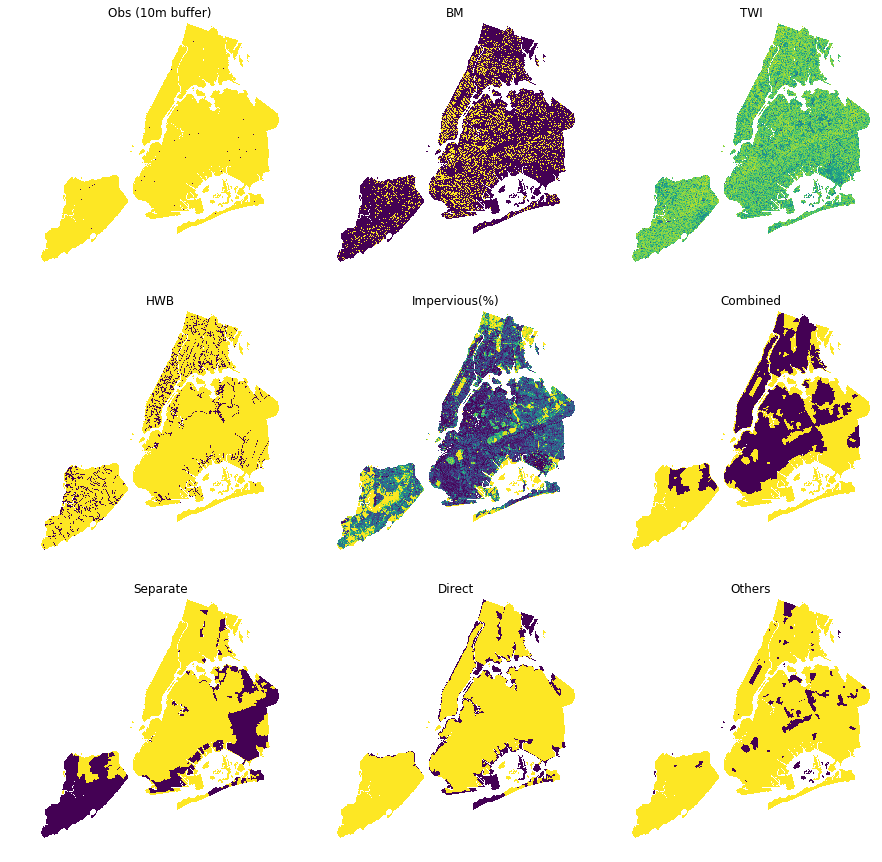

In [7]:
# visualize arrays

plt.figure(figsize=(15,15))
cmap = plt.cm.viridis_r
cmap.set_over('white')

ax1 = plt.subplot(3,3,1)
ax1.imshow(obs10mArray, vmin=0, vmax=1, cmap=cmap)
ax1.set_axis_off()
ax1.set_title('Obs (10m buffer)')

ax2 = plt.subplot(3,3,2)
ax2.imshow(BMarray, vmin=0, vmax=1, cmap=cmap)
ax2.set_axis_off()
ax2.set_title('BM')

ax3 = plt.subplot(3,3,3)
ax3.imshow(TWIarray_new, vmin=0, vmax=100, cmap=cmap)
ax3.set_axis_off()
ax3.set_title('TWI')

ax4 = plt.subplot(3,3,4)
ax4.imshow(HWBarray, vmin=0, vmax=1, cmap=cmap)
ax4.set_axis_off()
ax4.set_title('HWB')

ax5 = plt.subplot(3,3,5)
ax5.imshow(IMParray, vmin=0, vmax=100, cmap=cmap)
ax5.set_axis_off()
ax5.set_title('Impervious(%)')

ax6 = plt.subplot(3,3,6)
ax6.imshow(CSarray, vmin=0, vmax=1, cmap=cmap)
ax6.set_axis_off()
ax6.set_title('Combined')

ax7 = plt.subplot(3,3,7)
ax7.imshow(SSarray, vmin=0, vmax=1, cmap=cmap)
ax7.set_axis_off()
ax7.set_title('Separate')

ax8 = plt.subplot(3,3,8)
ax8.imshow(DSarray, vmin=0, vmax=1, cmap=cmap)
ax8.set_axis_off()
ax8.set_title('Direct')

ax9 = plt.subplot(3,3,9)
ax9.imshow(OSarray, vmin=0, vmax=1, cmap=cmap)
ax9.set_axis_off()
ax9.set_title('Others')

#### Stacking rasters:

In [8]:
arrays10m = TWIarray_new, HWBarray, IMParray, CSarray, SSarray, DSarray, OSarray, BMarray, obs10mArray
stacked10m = np.dstack(arrays10m)
print(stacked10m.shape)

(6282, 6331, 9)


In [9]:
final10m = stacked10m.reshape((39771342, 9))
print(final10m.shape)

(39771342, 9)


In [10]:
# checking
print(final10m[23000000])

[21  0 68  0  1  0  0  1  0]


#### Convert to pandas dataframes and save as csv (back up):
- uncomment to save as csv

In [11]:
columnNames = ['twi', 'hwb', 'imp', 'cs', 'ss', 'ds', 'os', 'bm', 'observed']

In [12]:
df10m = pd.DataFrame(final10m, columns=columnNames)
#df10m.to_csv('df10m.csv', index=False)

In [13]:
df10m.head()

,twi,hwb,imp,cs,ss,ds,os,bm,observed
0,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255


#### Remove rows containing 255 and save as csv with index (back up):
- uncomment to save as csv

In [14]:
# get indices of rows containing 255
nanindex_10m = np.unique(np.where(final10m == 255)[0])

# drop rows from df
df10m_nonan = df10m.drop(index=nanindex_10m)

print('Number of Rows Before: '+str(len(df10m)))
print('Number of Rows After: '+str(len(df10m_nonan)))

#save as csv with index
#df10m_nonan.to_csv('df10m_noNaN.csv', index=True, index_label='Index')

Number of Rows Before: 39771342
Number of Rows After: 13746346


Reduced number of rows by two-thirds for faster computation.

In [15]:
df10m_nonan.head()

,twi,hwb,imp,cs,ss,ds,os,bm,observed
225463,12,0,0,0,0,1,0,1,0
231793,16,0,0,0,0,1,0,1,0
231794,32,0,0,0,0,1,0,1,0
231795,39,0,0,0,0,1,0,1,0
231796,21,0,0,0,0,1,0,1,0


In [16]:
# check number of positive pixels
print('10m buffer:')
print(df10m_nonan['observed'].value_counts())

10m buffer:
0    13724427
1       21919
Name: observed, dtype: int64


#### Unlabel 30% of positives for validation of techniques:

In [17]:
# create copy for unlabeling
unlabel = df10m_nonan['observed'].copy()

# unlabel ~30% of positive data points, i.e. 6500 points
hidden_size = 6500
np.random.seed(seed=13)
unlabel.loc[np.random.choice(unlabel[unlabel == 1].index, replace=False, size=hidden_size)] = 0

# add unlabeled y column to df
df10m_nonan['y_un_30pct'] = unlabel
df10m_nonan.head()

print('Original: ')
print(df10m_nonan['observed'].value_counts())
print('')
print('After unlabeling: ')
print(df10m_nonan['y_un_30pct'].value_counts())

Original: 
0    13724427
1       21919
Name: observed, dtype: int64

After unlabeling: 
0    13730927
1       15419
Name: y_un_30pct, dtype: int64


#### Visually checking spatial distirbution of positives after unlabeling:

In [19]:
dist = pd.merge(df10m, df10m_nonan['y_un_30pct'], how='outer', left_index=True, right_index=True)
distArray = np.reshape(np.array(dist['y_un_30pct']), (6282, 6331))

Text(0.5,1,'After Unlabeling (10m buffer)')

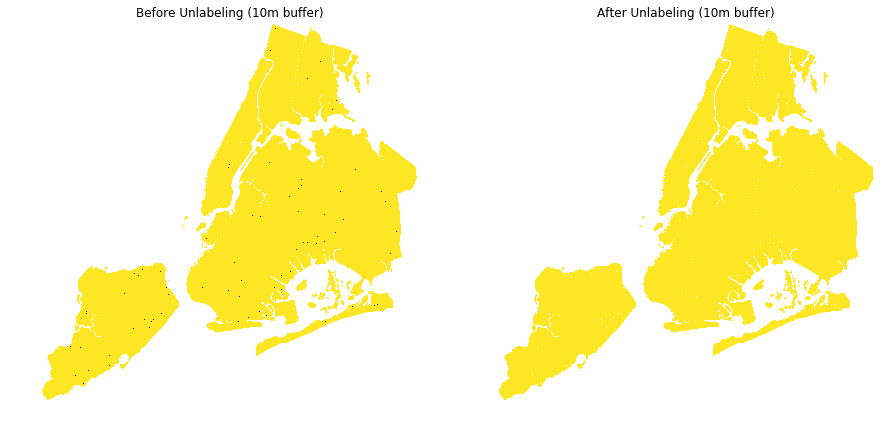

In [20]:
plt.figure(figsize=(15,8))
cmap = plt.cm.viridis_r
cmap.set_bad('white')

ax1 = plt.subplot(1,2,1)
ax1.imshow(obs10mArray, vmin=0, vmax=1, cmap=cmap)
ax1.set_axis_off()
ax1.set_title('Before Unlabeling (10m buffer)')

ax2 = plt.subplot(1,2,2)
ax2.imshow(distArray, vmin=0, vmax=1, cmap=cmap)
ax2.set_axis_off()
ax2.set_title('After Unlabeling (10m buffer)')

Seems to be sampled evenly, no single spot shows up after unlabeling.

#### Set X and y for training models:

In [41]:
X = df10m_nonan.iloc[:,:8]
y = df10m_nonan['y_un_30pct']

## Running Models
After training each model, we run it on all data points to get their corresponding scores. Ranking data points based on their scores, we expect to see more hidden positives (unlabeled 30%) showing up at the top. To compare the models, we will plot the percentages of hidden positives uncovered against the top x% of data points.

#### One Class Support Vector Machine (rbf kernel)
- Unsupervised Outlier Detection, binary result
- Train OCSVM on all positives, kernel = rbf
- Fit model to rest of data to identify inliers (possible positives) and outliers

In [68]:
# to perform SVM, have to normalize features
# create copy of df10m_nonan

df10m_norm = df10m_nonan.copy()

df10m_norm['twi'] = (df10m_nonan['twi'] - df10m_nonan['twi'].mean())/df10m_nonan['twi'].std()
df10m_norm['hwb'] = (df10m_nonan['hwb'] - df10m_nonan['hwb'].mean())/df10m_nonan['hwb'].std()
df10m_norm['imp'] = (df10m_nonan['imp'] - df10m_nonan['imp'].mean())/df10m_nonan['imp'].std()
df10m_norm['cs'] = (df10m_nonan['cs'] - df10m_nonan['cs'].mean())/df10m_nonan['cs'].std()
df10m_norm['ss'] = (df10m_nonan['ss'] - df10m_nonan['ss'].mean())/df10m_nonan['ss'].std()
df10m_norm['ds'] = (df10m_nonan['ds'] - df10m_nonan['ds'].mean())/df10m_nonan['ds'].std()
df10m_norm['os'] = (df10m_nonan['os'] - df10m_nonan['os'].mean())/df10m_nonan['os'].std()
df10m_norm['bm'] = (df10m_nonan['bm'] - df10m_nonan['bm'].mean())/df10m_nonan['bm'].std()
df10m_norm.head()

,twi,hwb,imp,cs,ss,ds,os,bm,observed,y_un_30pct,gmmscore,gmmscore_exp,rf_100,bc_30,tsm
225463,-1.357629,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-27.039072,1.807509e-12,0.0,0.0,0.0
231793,-1.010156,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-26.546548,2.957881e-12,0.0,0.0,0.0
231794,0.379735,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-25.581105,7.767253e-12,0.0,0.0,0.0
231795,0.987812,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-25.664189,7.147999e-12,0.0,0.0,0.0
231796,-0.575815,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-26.072172,4.753347e-12,0.0,0.0,0.0


In [69]:
# train on labeled positives and test on unknown labels
# hidden positives should show up as 1s (inliers)

occX_train = df10m_norm[df10m_norm['y_un_30pct'] == 1].iloc[:, :8]
occX_test = df10m_norm[df10m_norm['y_un_30pct'] != 1].iloc[:, :8]

In [70]:
OCC = OneClassSVM(random_state=13, kernel='rbf')
OCC.fit(occX_train)

/nfshome/rms818/.conda/envs/myEnv/lib/python2.7/site-packages/sklearn/svm/classes.py:1137: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)
/nfshome/rms818/.conda/envs/myEnv/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, random_state=13, shrinking=True,
      tol=0.001, verbose=False)

In [71]:
values, counts = np.unique(OCC.predict(occX_train), return_counts=True)
print(values)
print(counts)

[-1  1]
[7717 7702]


In [72]:
df10m_norm['occ_rbf'] = OCC.predict(df10m_norm.iloc[:,:8])

In [73]:
unCounts_occ = df10m_norm[(df10m_norm['observed']==1)&(df10m_norm['y_un_30pct']==0)]['occ_rbf'].value_counts()

In [74]:
pct_occ = unCounts_occ[1]*100.0/6500
print('%.2f percent of hidden positives uncovered.' %pct_occ)

50.00 percent of hidden positives uncovered.


In [75]:
occdf = df10m.merge(df10m_norm['occ_rbf'], how='outer', left_index=True, right_index=True)
occdf['occ_rbf'].fillna(255, inplace=True)
occplot = np.reshape(np.array(occdf['occ_rbf']), (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

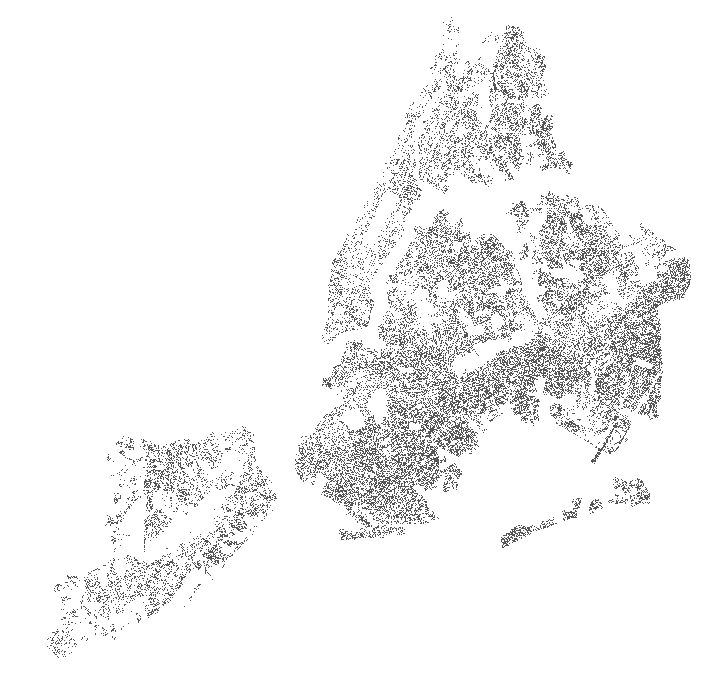

In [76]:
plt.figure(figsize=(12,12))
cmap = plt.cm.binary
cmap.set_over('white')
plt.imshow(occplot, vmin=-1, vmax=2, cmap=cmap)
plt.axis('off')

In [77]:
with rio.open(tifFolder + 'Topographic_Wetness_Index.tif') as src:
    twi_ras = src.read()
    twi_meta = src.profile
    
print(twi_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 3.4028234663852886e+38}


In [78]:
occrbftif = occplot.astype('float32')

with rio.open('occ_rbf.tif', 'w', **twi_meta) as dst:
    dst.write(occrbftif, 1)

#### One Class Support Vector Machine (sigmoid kernel)
- Unsupervised Outlier Detection, binary result
- Train OCSVM on all positives, kernel = sigmoid
- Fit model to rest of data to identify inliers (possible positives) and outliers

In [79]:
OCC2 = OneClassSVM(random_state=13, kernel='sigmoid')
OCC2.fit(occX_train)

/nfshome/rms818/.conda/envs/myEnv/lib/python2.7/site-packages/sklearn/svm/classes.py:1137: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='sigmoid', max_iter=-1, nu=0.5, random_state=13,
      shrinking=True, tol=0.001, verbose=False)

In [80]:
values, counts = np.unique(OCC.predict(occX_train), return_counts=True)
print(values)
print(counts)

[-1  1]
[7717 7702]


In [81]:
df10m_norm['occ_sig'] = OCC2.predict(df10m_norm.iloc[:,:8])

In [82]:
unCounts_occ2 = df10m_norm[(df10m_norm['observed']==1)&(df10m_norm['y_un_30pct']==0)]['occ_sig'].value_counts()

In [83]:
pct_occ2 = unCounts_occ2[1]*100.0/6500
print('%.2f percent of hidden positives uncovered.' %pct_occ2)

49.95 percent of hidden positives uncovered.


In [84]:
occ2df = df10m.merge(df10m_norm['occ_sig'], how='outer', left_index=True, right_index=True)
occ2df['occ_sig'].fillna(255, inplace=True)
occ2plot = np.reshape(np.array(occ2df['occ_sig']), (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

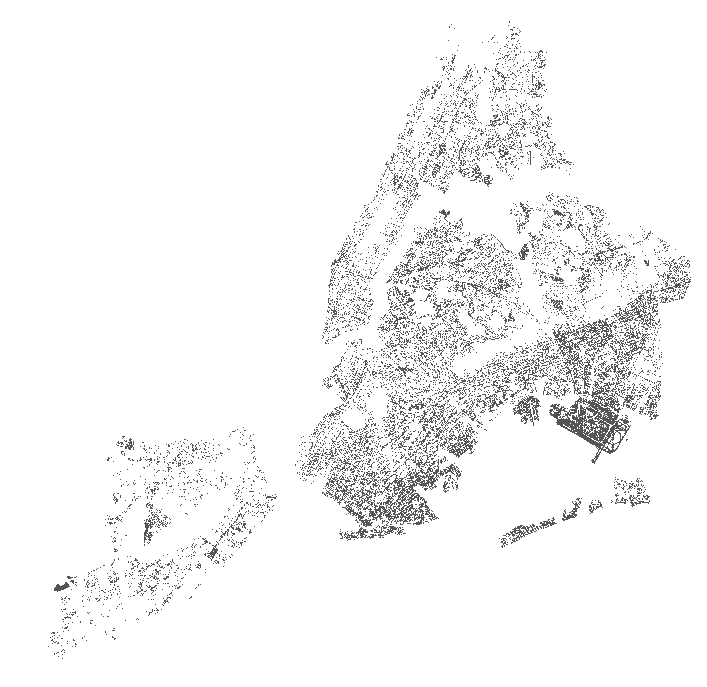

In [85]:
plt.figure(figsize=(12,12))
cmap = plt.cm.binary
cmap.set_over('white')
plt.imshow(occ2plot, vmin=-1, vmax=2, cmap=cmap)
plt.axis('off')

In [86]:
with rio.open(tifFolder + 'Topographic_Wetness_Index.tif') as src:
    twi_ras = src.read()
    twi_meta = src.profile
    
print(twi_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 3.4028234663852886e+38}


In [87]:
occsigtif = occ2plot.astype('float32')

with rio.open('occ_sig.tif', 'w', **twi_meta) as dst:
    dst.write(occsigtif, 1)

#### Gaussian Mixture Model
- Build model on positives only
- Fit model to rest of data to get likelihood scores

In [21]:
gmmX = df10m_nonan[df10m_nonan['y_un_30pct']==1].iloc[:,:8]
gmmX.head()

,twi,hwb,imp,cs,ss,ds,os,bm
681346,28,0,10,1,0,0,0,1
681347,31,0,7,1,0,0,0,1
687677,18,0,10,1,0,0,0,1
713051,19,0,69,1,0,0,0,1
713052,51,0,68,1,0,0,0,1


In [22]:
GMM = GaussianMixture(n_components=1, random_state=13)
GMM.fit(gmmX)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [23]:
# score_samples return weighted log probabilities
df10m_nonan['gmmscore'] = GMM.score_samples(df10m_nonan.iloc[:,:8])

# we look at exponentials for easier understanding
df10m_nonan['gmmscore_exp'] = np.exp(df10m_nonan['gmmscore'])

In [24]:
# sort by scores
gmmSorted = df10m_nonan.sort_values('gmmscore_exp', ascending=False)

In [25]:
# extract % of hidden positives uncovered in top x% of data

n = int(len(gmmSorted)/20)
gmmRanked = []

for i in range(21):
    ind = int(i*n)
    gmmpct = gmmSorted[:ind]
    unCounts_gmm = len(gmmpct[(gmmpct['observed']==1)&(gmmpct['y_un_30pct']==0)])
    pctPos_gmm = unCounts_gmm*100.0/6500
    gmmRanked.append(pctPos_gmm)

gmmRanked

[0.0,
 10.907692307692308,
 22.723076923076924,
 33.15384615384615,
 42.784615384615385,
 52.353846153846156,
 61.33846153846154,
 69.27692307692308,
 76.75384615384615,
 83.0923076923077,
 90.07692307692308,
 95.26153846153846,
 95.76923076923077,
 99.0,
 99.3076923076923,
 99.6923076923077,
 99.73846153846154,
 99.78461538461538,
 99.87692307692308,
 99.8923076923077,
 100.0]

In [26]:
# merge scores with original dataframe for plotting
gmmdf = df10m.merge(df10m_nonan['gmmscore_exp'], how='outer', left_index=True, right_index=True)

# multiply by 100 for readability and reshape into 6282 by 6331 array 
gmmplot = np.reshape(np.array(gmmdf['gmmscore_exp'])*100.0, (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

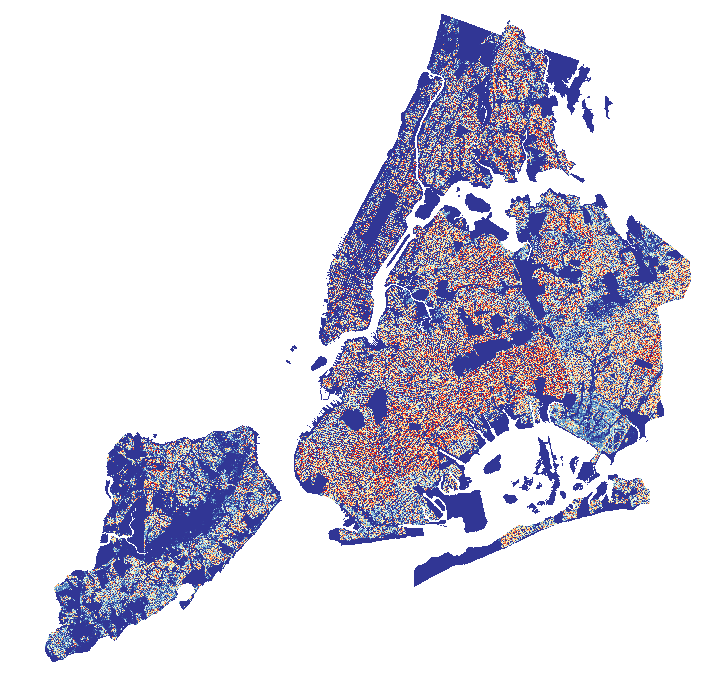

In [40]:
# visually check if everything above worked
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_bad('white')
plt.imshow(gmmplot, vmin=0, vmax=140, cmap=cmap)
plt.axis('off')

In [28]:
# get original metadata from original rasters - we use TWI here
with rio.open(tifFolder + 'Topographic_Wetness_Index.tif') as src:
    twi_ras = src.read()
    twi_meta = src.profile
    
print(twi_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 3.4028234663852886e+38}


In [29]:
# change datatype to 'float32'
gmmtif = gmmplot.astype('float32')

# writing and saving as raster
with rio.open('gmm.tif', 'w', **twi_meta) as dst:
    dst.write(gmmtif, 1)

#### Random Forest Classifier with n_estimators=100
- Build model on all positive and unlabeled data
- Fit model to all data to get mean predicted class probabilities (predict_proba)

In [31]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=13)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [32]:
df10m_nonan['rf_100'] = rf.predict_proba(X)[:,1]
df10m_nonan['rf_100'].describe()

count    1.374635e+07
mean     1.123167e-03
std      2.855551e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.602927e-03
max      6.674524e-01
Name: rf_100, dtype: float64

(-0.001, 0.005)

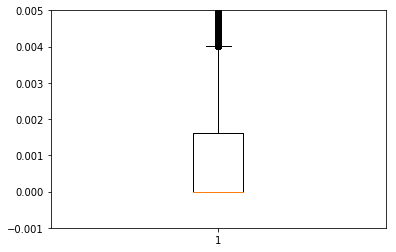

In [33]:
plt.boxplot(df10m_nonan['rf_100'])
plt.ylim(-0.001, 0.005)

In [34]:
rfSorted = df10m_nonan.sort_values('rf_100', ascending=False)

In [37]:
n = int(len(rfSorted)/20)
rfRanked = []

for i in range(21):
    ind = int(i*n)
    rfpct = rfSorted[:ind]
    unCounts_rf = len(rfpct[(rfpct['observed']==1)&(rfpct['y_un_30pct']==0)])
    pctPos_rf = unCounts_rf*100.0/6500
    rfRanked.append(pctPos_rf)
    
rfRanked

[0.0,
 17.153846153846153,
 30.4,
 40.98461538461538,
 50.47692307692308,
 58.707692307692305,
 65.33846153846154,
 72.76923076923077,
 78.46153846153847,
 80.96923076923076,
 83.18461538461538,
 85.67692307692307,
 88.23076923076923,
 91.18461538461538,
 92.03076923076924,
 93.24615384615385,
 94.24615384615385,
 96.04615384615384,
 97.06153846153846,
 98.46153846153847,
 100.0]

In [38]:
rfdf = df10m.merge(df10m_nonan['rf_100'], how='outer', left_index=True, right_index=True)
rfplot = np.reshape(np.array(rfdf['rf_100'])*100.0, (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

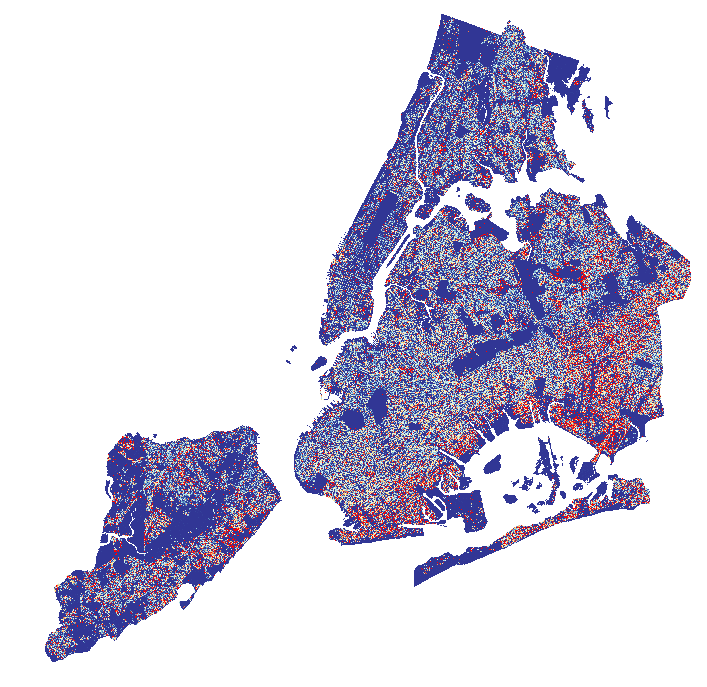

In [39]:
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_over('red')
cmap.set_bad('white')
plt.imshow(rfplot, vmin=0, vmax=0.45, cmap=cmap)
plt.axis('off')

In [42]:
with rio.open(tifFolder + 'Topographic_Wetness_Index.tif') as src:
    twi_ras = src.read()
    twi_meta = src.profile
    
print(twi_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 3.4028234663852886e+38}


In [43]:
rftif = rfplot.astype('float32')

with rio.open('rf.tif', 'w', **twi_meta) as dst:
    dst.write(rftif, 1)

#### Random Forest Classifier with Bagging, n_estimators=30
- Build each Decision Tree on all positives and randomly sampled subset of unlabeled data
- Fit model to all data to get mean of scores from out-of-bag estimate (oob_decision_function)
- NaNs will be present since all positives were never left out, we will change the NaNs to 1

In [46]:
bc = BaggingClassifierPU(DecisionTreeClassifier(), 
                          n_estimators=30, n_jobs=-1, 
                          random_state=13, max_samples=sum(y))
bc.fit(X, y)

BaggingClassifierPU(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=15419, n_estimators=30, n_jobs=-1, oob_score=True,
          random_state=13, verbose=0, warm_start=False)

In [47]:
df10m_nonan['bc_30'] = bc.oob_decision_function_[:,1]
df10m_nonan['bc_30'].describe()

count    1.373093e+07
mean     3.349545e-01
std      3.321906e-01
min      0.000000e+00
25%      0.000000e+00
50%      2.756746e-01
75%      6.535154e-01
max      1.000000e+00
Name: bc_30, dtype: float64

In [48]:
bcSorted = df10m_nonan.sort_values('bc_30', ascending=False)

In [49]:
n = int(len(bcSorted)/20)
bcRanked = []

for i in range(21):
    ind = int(i*n)
    bcpct = bcSorted[:ind]
    unCounts_bc = len(bcpct[(bcpct['observed']==1)&(bcpct['y_un_30pct']==0)])
    pctPos_bc = unCounts_bc*100.0/6500
    bcRanked.append(pctPos_bc)

bcRanked

[0.0,
 16.861538461538462,
 31.107692307692307,
 43.12307692307692,
 52.646153846153844,
 61.58461538461538,
 69.29230769230769,
 76.44615384615385,
 83.0,
 89.43076923076923,
 94.06153846153846,
 97.16923076923077,
 98.52307692307693,
 99.12307692307692,
 99.3076923076923,
 99.50769230769231,
 99.58461538461539,
 99.6923076923077,
 99.76923076923077,
 99.8923076923077,
 100.0]

In [50]:
print('Number of NaNs (positives): ')
print(df10m_nonan['bc_30'].isna().sum())
print(' ')

# replace NaNs with 1 for plotting
df10m_nonan['bc_30'].fillna(1, inplace=True)

print('Number of NaNs: ')
print(df10m_nonan['bc_30'].isna().sum())

Number of NaNs (positives): 
15419
 
Number of NaNs: 
0


{'boxes': [<matplotlib.lines.Line2D at 0x7fd0f3819c10>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd0f3825490>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd0f3825fd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd0f3825c10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd0f3819cd0>,
  <matplotlib.lines.Line2D at 0x7fd0f38250d0>]}

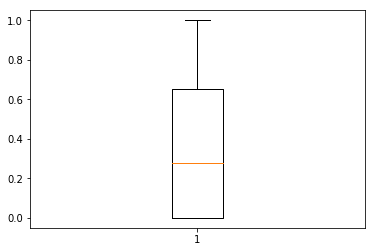

In [51]:
plt.boxplot(df10m_nonan['bc_30'])

In [52]:
bcdf = df10m.merge(df10m_nonan['bc_30'], how='outer', left_index=True, right_index=True)
bcplot = np.reshape(np.array(bcdf['bc_30'])*100.0, (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

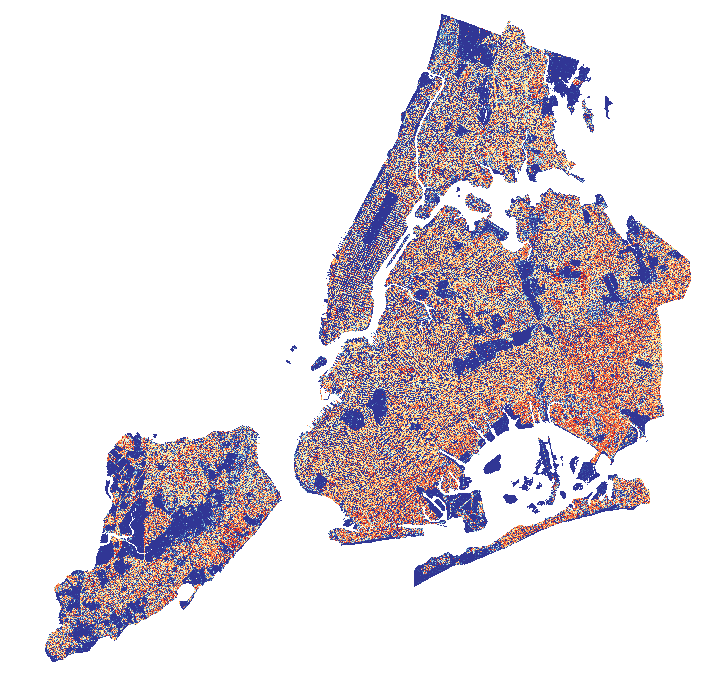

In [53]:
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_bad('white')
plt.imshow(bcplot, vmin=0, vmax=100, cmap=cmap)
plt.axis('off')

In [54]:
with rio.open(tifFolder + 'Topographic_Wetness_Index.tif') as src:
    twi_ras = src.read()
    twi_meta = src.profile
    
print(twi_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 3.4028234663852886e+38}


In [55]:
bctif = bcplot.astype('float32')

with rio.open('bc.tif', 'w', **twi_meta) as dst:
    dst.write(bctif, 1)

#### Iterative Random Forest Classifier , n_estimators=100
- Two-Step Approach:
    1. Using RF Classifier, label unknowns as either positives or reliable negatives
    2. Retrain RF Classifier on newly labeled data and repeat step 1 until no more positives or negatives are identified
- Fit last model to all data to get mean predicted class probabilities (predict_proba)
- In this case we will only be repeating this process five times because computation is costly

In [56]:
# relabel positives as 1, unlabeled as -1, negatives as 0. No negatives in this case yet
ys = 2 * y - 1

# use rf model with n_estimator=100 (above) to generate reliable negatives
pred = rf.predict_proba(X)[:,1]

# find range of scores given to known positives
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
print(range_P)

[0.0, 0.6674523809523809]


In [57]:
# relabeling
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index

ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

In [58]:
# setting up new classifier
TSM = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [59]:
for i in range(5):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        print('end')
        break
    
    print('Step 1 labeled %d new positives and %d new negatives.' % (len(iP_new), len(iN_new)))
    print('Doing step 2... ')

    # Retrain on new labels and get new scores
    TSM.fit(X, ys)
    pred = TSM.predict_proba(X)[:,-1]

    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0

Step 1 labeled 0 new positives and 7988905 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 427 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 120 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 56 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 43 new negatives.
Doing step 2... 


In [60]:
df10m_nonan['tsm'] = pred
df10m_nonan['tsm'].describe()

count    1.374635e+07
mean     1.120493e-03
std      2.844487e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.598546e-03
max      7.871667e-01
Name: tsm, dtype: float64

(-0.001, 0.004)

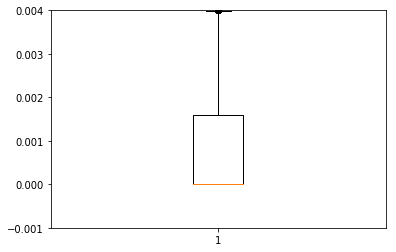

In [61]:
plt.boxplot(df10m_nonan['tsm'])
plt.ylim(-0.001, 0.004)

In [62]:
tsmSorted = df10m_nonan.sort_values('tsm', ascending=False)

In [63]:
n = int(len(tsmSorted)/20)
tsmRanked = []

for i in range(21):
    ind = int(i*n)
    tsmpct = tsmSorted[:ind]
    unCounts_tsm = len(tsmpct[(tsmpct['observed']==1)&(tsmpct['y_un_30pct']==0)])
    pctPos_tsm = unCounts_tsm*100.0/6500
    tsmRanked.append(pctPos_tsm)

In [64]:
tsmdf = df10m.merge(df10m_nonan['tsm'], how='outer', left_index=True, right_index=True)
tsmplot = np.reshape(np.array(tsmdf['tsm'])*100.0, (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

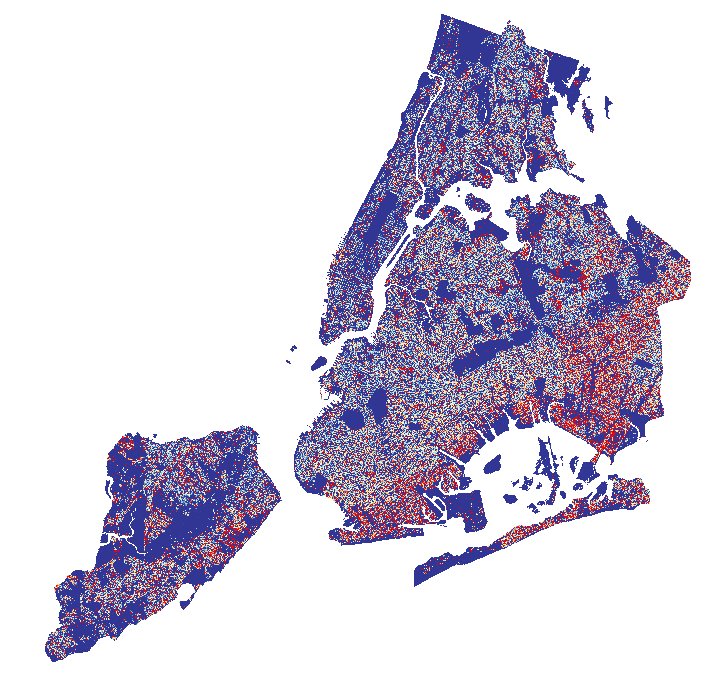

In [65]:
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_bad('white')
plt.imshow(tsmplot, vmin=0, vmax=0.4, cmap=cmap)
plt.axis('off')

In [66]:
with rio.open(tifFolder + 'Topographic_Wetness_Index.tif') as src:
    twi_ras = src.read()
    twi_meta = src.profile
    
print(twi_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 3.4028234663852886e+38}


In [67]:
tsmtif = tsmplot.astype('float32')

with rio.open('tsm.tif', 'w', **twi_meta) as dst:
    dst.write(tsmtif, 1)

#### Plotting percentage of hidden positives uncovered:

In [123]:
# create dataframe from saved values
rankDf = pd.DataFrame({'gmm': gmmRanked,
                      'rf': rfRanked,
                      'bc': bcRanked,
                      'tsm': tsmRanked,
                      'pct': range(0, 101, 5)})

In [124]:
rankDf.head()

,bc,gmm,pct,rf,tsm
0,0.000000,0.000000,0,0.000000,0.000000
1,16.861538,10.907692,5,17.153846,17.153846
2,31.107692,22.723077,10,30.400000,30.276923
3,43.123077,33.153846,15,40.984615,41.107692
4,52.646154,42.784615,20,50.476923,50.276923


In [219]:
rankDf.to_csv('rankings.csv', index=False)

Text(0.5,1,'Percentage of Hidden Positives Uncovered against Top x% of Scores')

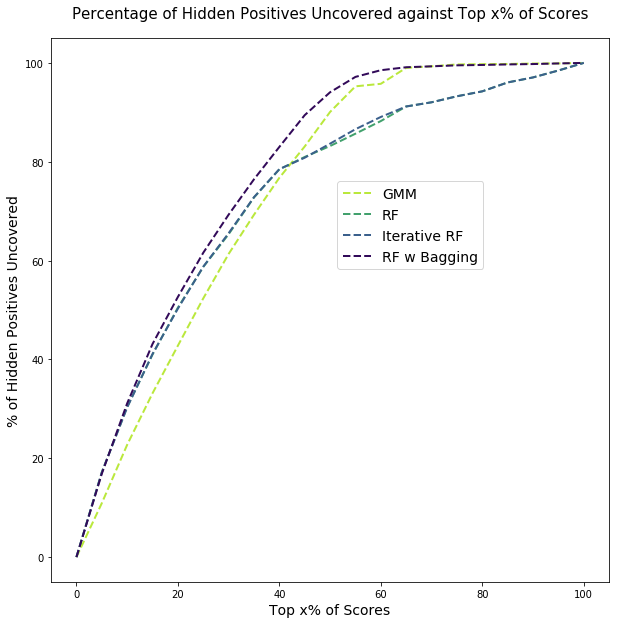

In [221]:
# without zoom
plt.figure(figsize=(10,10))
plt.plot(rankDf['pct'], rankDf['gmm'], label='GMM', linewidth=2, color='#bae83c', ls='dashed')
plt.plot(rankDf['pct'], rankDf['rf'], label='RF', linewidth=2, color='#42a16d', ls='dashed')
plt.plot(rankDf['pct'], rankDf['tsm'], label='Iterative RF', linewidth=2, color='#3b608c', ls='dashed')
plt.plot(rankDf['pct'], rankDf['bc'], label='RF w Bagging', linewidth=2, color='#320a59', ls='dashed')
plt.legend(bbox_to_anchor=(0.5, 0.75), fontsize=14)
plt.xlabel('Top x% of Scores', fontsize=14)
plt.ylabel('% of Hidden Positives Uncovered', fontsize=14)
plt.title('Percentage of Hidden Positives Uncovered against Top x% of Scores', fontsize=15, pad=20)

(-1, 70)

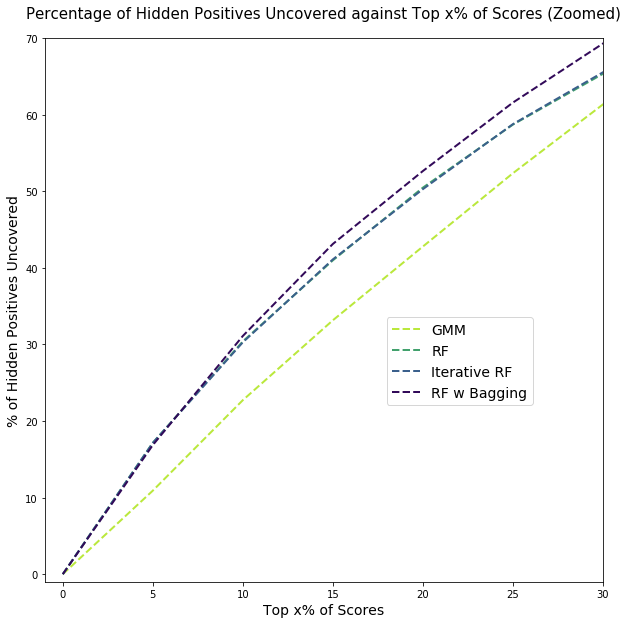

In [218]:
# with zoom
plt.figure(figsize=(10,10))
plt.plot(rankDf['pct'], rankDf['gmm'], label='GMM', linewidth=2, color='#bae83c', ls='dashed')
plt.plot(rankDf['pct'], rankDf['rf'], label='RF', linewidth=2, color='#42a16d', ls='dashed')
plt.plot(rankDf['pct'], rankDf['tsm'], label='Iterative RF', linewidth=2, color='#3b608c', ls='dashed')
plt.plot(rankDf['pct'], rankDf['bc'], label='RF w Bagging', linewidth=2, color='#320a59', ls='dashed')
plt.legend(bbox_to_anchor=(0.6, 0.5), fontsize=14)
plt.xlabel('Top x% of Scores', fontsize=14)
plt.ylabel('% of Hidden Positives Uncovered', fontsize=14)
plt.title('Percentage of Hidden Positives Uncovered against Top x% of Scores (Zoomed)', fontsize=15, pad=20)
plt.xlim(-1,30)
plt.ylim(-1,70)